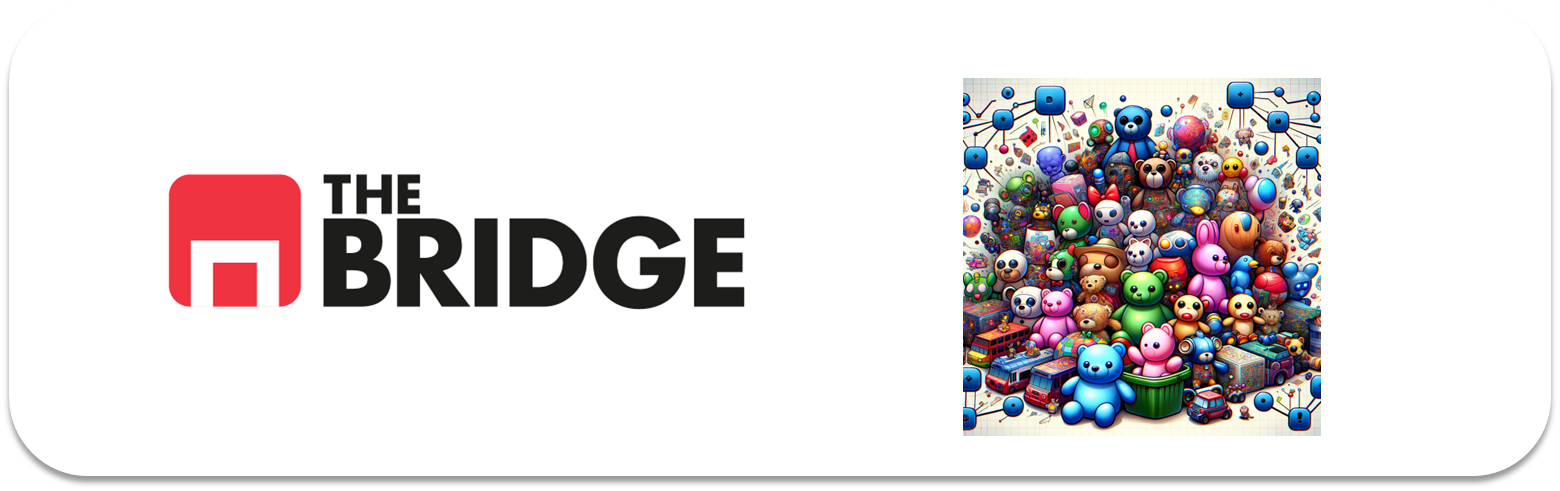

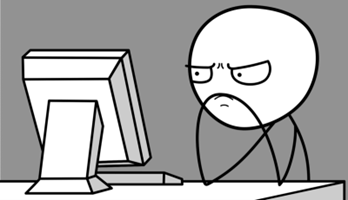

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [65]:
import pandas as pd
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [66]:
data = pd.read_csv('./data/drugLibTrain_raw.tsv', sep="\t")
data

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...,...
3102,1039,vyvanse,10,Highly Effective,Mild Side Effects,adhd,"Increased focus, attention, productivity. Bett...","Restless legs at night, insomnia, headache (so...","I took adderall once as a child, and it made m..."
3103,3281,zoloft,1,Ineffective,Extremely Severe Side Effects,depression,Emotions were somewhat blunted. Less moodiness.,"Weight gain, extreme tiredness during the day,...",I was on Zoloft for about 2 years total. I am ...
3104,1664,climara,2,Marginally Effective,Moderate Side Effects,total hysterctomy,---,Constant issues with the patch not staying on....,---
3105,2621,trileptal,8,Considerably Effective,Mild Side Effects,epilepsy,Controlled complex partial seizures.,"Dizziness, fatigue, nausea",Started at 2 doses of 300 mg a day and worked ...


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


In [68]:
data.effectiveness.value_counts(normalize=True)

effectiveness
Highly Effective          0.428066
Considerably Effective    0.298680
Moderately Effective      0.133569
Ineffective               0.079498
Marginally Effective      0.060187
Name: proportion, dtype: float64

In [69]:
data.sideEffects.value_counts(normalize=True)

sideEffects
Mild Side Effects                0.327969
No Side Effects                  0.299324
Moderate Side Effects            0.197618
Severe Side Effects              0.118764
Extremely Severe Side Effects    0.056324
Name: proportion, dtype: float64

In [70]:
data.condition.value_counts(normalize=True)

condition
depression                                          0.075982
acne                                                0.053123
anxiety                                             0.020283
insomnia                                            0.017386
birth control                                       0.015776
                                                      ...   
panic attacks, depression                           0.000322
extrinsic aging                                     0.000322
all over and various type pain                      0.000322
excessive coughing, later diagnosed as pneumonia    0.000322
total hysterctomy                                   0.000322
Name: proportion, Length: 1426, dtype: float64

Variables seleccionadas:
* rating
* sideEffects
* effectiveness

### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [71]:
# Calcular la cardinalidad absoluta
cardinalidad_abs = data.nunique()

# Calcular la cardinalidad relativa (porcentaje)
cardinalidad_pct = (cardinalidad_abs / len(data)) * 100

# Combinar en un DataFrame
cardinalidad_df = pd.DataFrame({
    "Cardinalidad Absoluta": cardinalidad_abs,
    "Cardinalidad (%)": cardinalidad_pct
})

# Mostrar los resultados
print(cardinalidad_df)

                   Cardinalidad Absoluta  Cardinalidad (%)
Unnamed: 0                          3107        100.000000
urlDrugName                          502         16.157065
rating                                10          0.321854
effectiveness                          5          0.160927
sideEffects                            5          0.160927
condition                           1426         45.896363
benefitsReview                      3031         97.553911
sideEffectsReview                   2813         90.537496
commentsReview                      3046         98.036691


In [72]:
data_train = data[['rating','effectiveness','sideEffects']]
data_train

,rating,effectiveness,sideEffects
0,4,Highly Effective,Mild Side Effects
1,1,Highly Effective,Severe Side Effects
2,10,Highly Effective,No Side Effects
3,3,Marginally Effective,Mild Side Effects
4,2,Marginally Effective,Severe Side Effects
...,...,...,...
3102,10,Highly Effective,Mild Side Effects
3103,1,Ineffective,Extremely Severe Side Effects
3104,2,Marginally Effective,Moderate Side Effects
3105,8,Considerably Effective,Mild Side Effects


### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [73]:
X = data_train
X

,rating,effectiveness,sideEffects
0,4,Highly Effective,Mild Side Effects
1,1,Highly Effective,Severe Side Effects
2,10,Highly Effective,No Side Effects
3,3,Marginally Effective,Mild Side Effects
4,2,Marginally Effective,Severe Side Effects
...,...,...,...
3102,10,Highly Effective,Mild Side Effects
3103,1,Ineffective,Extremely Severe Side Effects
3104,2,Marginally Effective,Moderate Side Effects
3105,8,Considerably Effective,Mild Side Effects


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [74]:
# Transformar effectiveness
X.effectiveness.value_counts()

# Mapeo de valores categóricos a numéricos para effectiveness
effectiveness_map = {
    "Highly Effective": 4,
    "Considerably Effective":3, 
    "Moderately Effective": 2,
    "Marginally Effective": 1,
    "Ineffective": 0
}

# Aplicar la transformación usando .loc[]
X.loc[:, "effectiveness"] = X["effectiveness"].map(effectiveness_map)

# Verificar la transformación
print(X.head())

   rating effectiveness          sideEffects
0       4             4    Mild Side Effects
1       1             4  Severe Side Effects
2      10             4      No Side Effects
3       3             1    Mild Side Effects
4       2             1  Severe Side Effects


In [75]:
# Transformar sideEffects
X.sideEffects.value_counts()

sideEffects
Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: count, dtype: int64

In [76]:
# Transformar sideEffects
X.sideEffects.value_counts()

# Mapeo de valores categóricos a numéricos para effectiveness
sideEffects_map = {
    "No Side Effects": 4,
    "Mild Side Effects":3, 
    "Moderate Side Effects": 2,
    "Severe Side Effects": 1,
    "Extremely Severe Side Effects": 0
}

# Aplicar la transformación usando .loc[]
X.loc[:, "sideEffects"] = X["sideEffects"].map(sideEffects_map)

# Verificar la transformación
X

,rating,effectiveness,sideEffects
0,4,4,3
1,1,4,1
2,10,4,4
3,3,1,3
4,2,1,1
...,...,...,...
3102,10,4,3
3103,1,0,0
3104,2,1,2
3105,8,3,3


In [77]:
X.isna().sum()

rating           0
effectiveness    0
sideEffects      0
dtype: int64

In [78]:
from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Aplicar la estandarización
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Mostrar los datos estandarizados
print(X_scaled.head())

     rating  effectiveness  sideEffects
0 -1.023494       0.865108     0.258895
1 -2.044907       0.865108    -1.439917
2  1.019330       0.865108     1.108302
3 -1.363965      -1.573256     0.258895
4 -1.704436      -1.573256    -1.439917


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

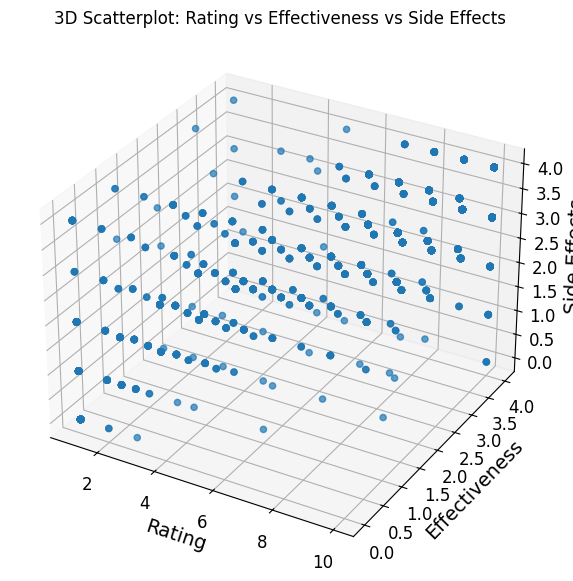

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear figura y ejes 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot 3D
ax.scatter(X["rating"], X["effectiveness"], X["sideEffects"], alpha=0.7)

# Etiquetas de los ejes
ax.set_xlabel("Rating")
ax.set_ylabel("Effectiveness")
ax.set_zlabel("Side Effects")
ax.set_title("3D Scatterplot: Rating vs Effectiveness vs Side Effects")

# Mostrar el gráfico
plt.show()


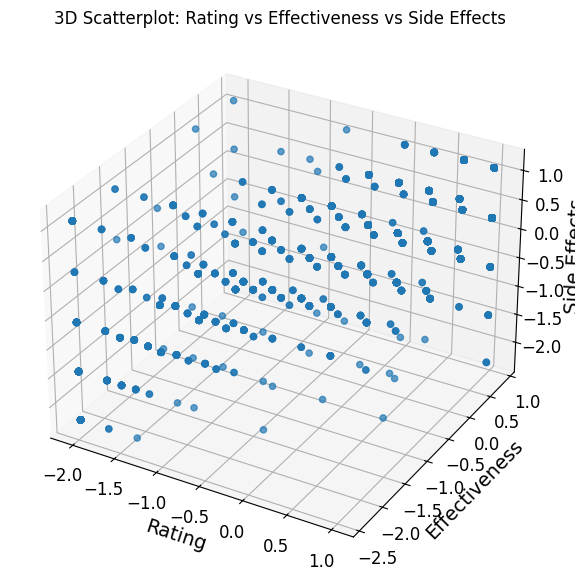

In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear figura y ejes 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot 3D
ax.scatter(X_scaled["rating"], X_scaled["effectiveness"], X_scaled["sideEffects"], alpha=0.7)

# Etiquetas de los ejes
ax.set_xlabel("Rating")
ax.set_ylabel("Effectiveness")
ax.set_zlabel("Side Effects")
ax.set_title("3D Scatterplot: Rating vs Effectiveness vs Side Effects")

# Mostrar el gráfico
plt.show()

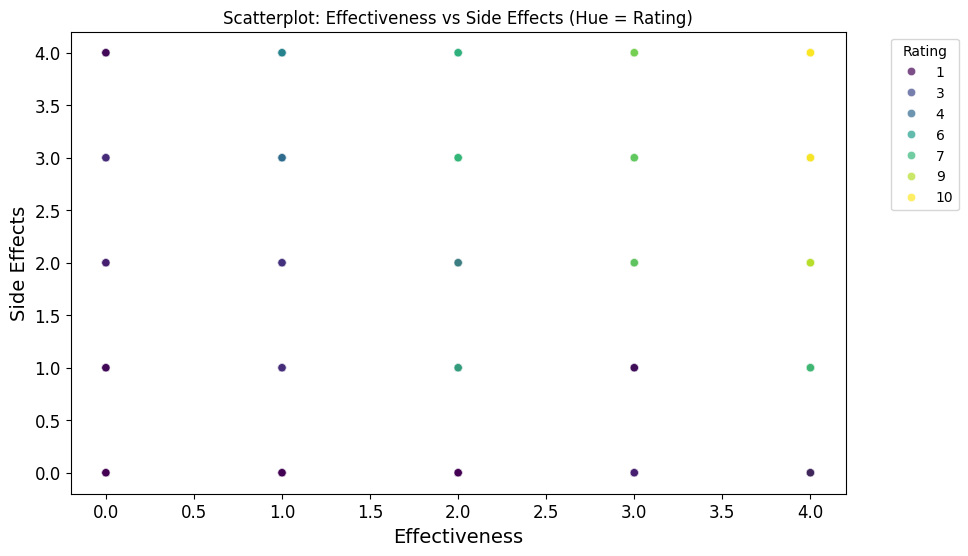

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear scatterplot con rating como hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X["effectiveness"], y=X["sideEffects"], hue=X["rating"], palette="viridis", alpha=0.7)

# Etiquetas y título
plt.xlabel("Effectiveness")
plt.ylabel("Side Effects")
plt.title("Scatterplot: Effectiveness vs Side Effects (Hue = Rating)")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")

# Mostrar gráfico
plt.show()


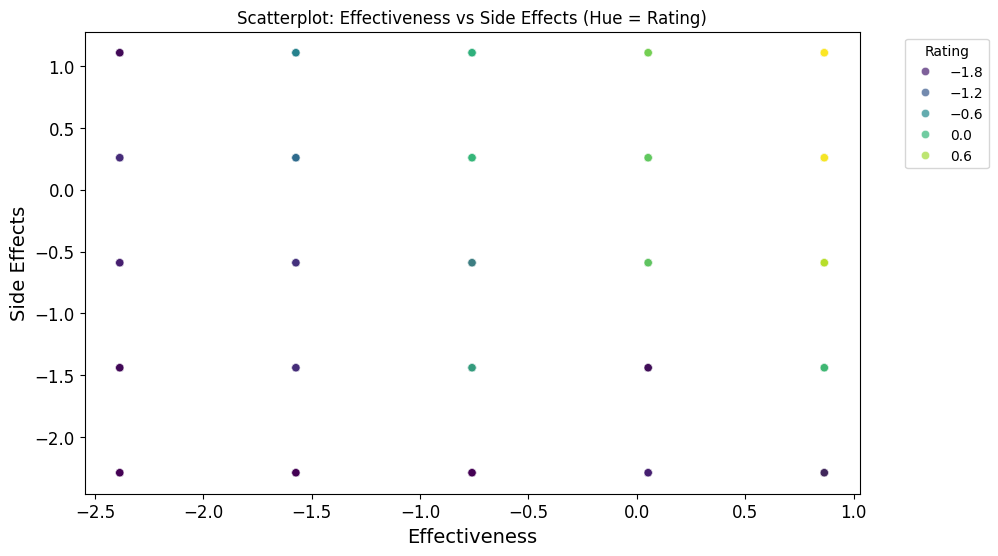

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear scatterplot con rating como hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled["effectiveness"], y=X_scaled["sideEffects"], hue=X_scaled["rating"], palette="viridis", alpha=0.7)

# Etiquetas y título
plt.xlabel("Effectiveness")
plt.ylabel("Side Effects")
plt.title("Scatterplot: Effectiveness vs Side Effects (Hue = Rating)")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")

# Mostrar gráfico
plt.show()

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

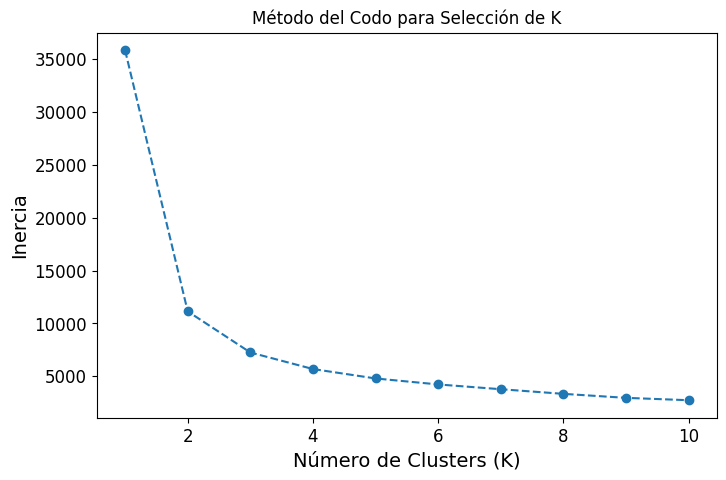

In [83]:
from sklearn.cluster import KMeans

K_range = range(1, 11) 

# Calculo de diferentes modelos para diferentes valores de k, con fit
kmeans_per_k = [KMeans(n_clusters=k, random_state= 42, n_init = 25).fit(X)
                for k in K_range]

# Extraer los valores de inercia para los modelos calculados
inertias = [model.inertia_ for model in kmeans_per_k]

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o', linestyle='--')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo para Selección de K")
plt.show()

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

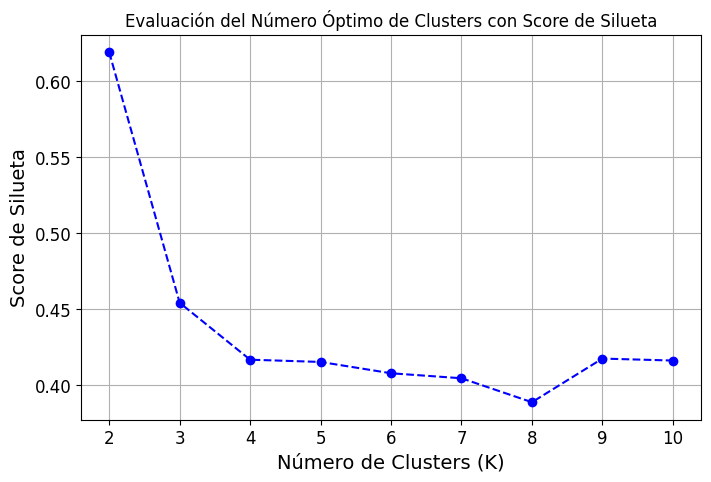

El mejor número de clusters según el score de silueta es K=2


In [84]:
from sklearn.metrics import silhouette_score

# Rango de K probado en el ejercicio anterior
K_range = range(2, 11)  # No se prueba K=1 porque no tiene sentido calcular la silueta

# Extraer los valores de silhouette_scores para los modelos
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

# Graficar la evolución del score de silueta con K
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Score de Silueta")
plt.title("Evaluación del Número Óptimo de Clusters con Score de Silueta")
plt.grid(True)
plt.show()

# Encontrar el K con el mayor score de silueta
best_k = K_range[np.argmax(silhouette_scores)]
print(f"El mejor número de clusters según el score de silueta es K={best_k}")

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

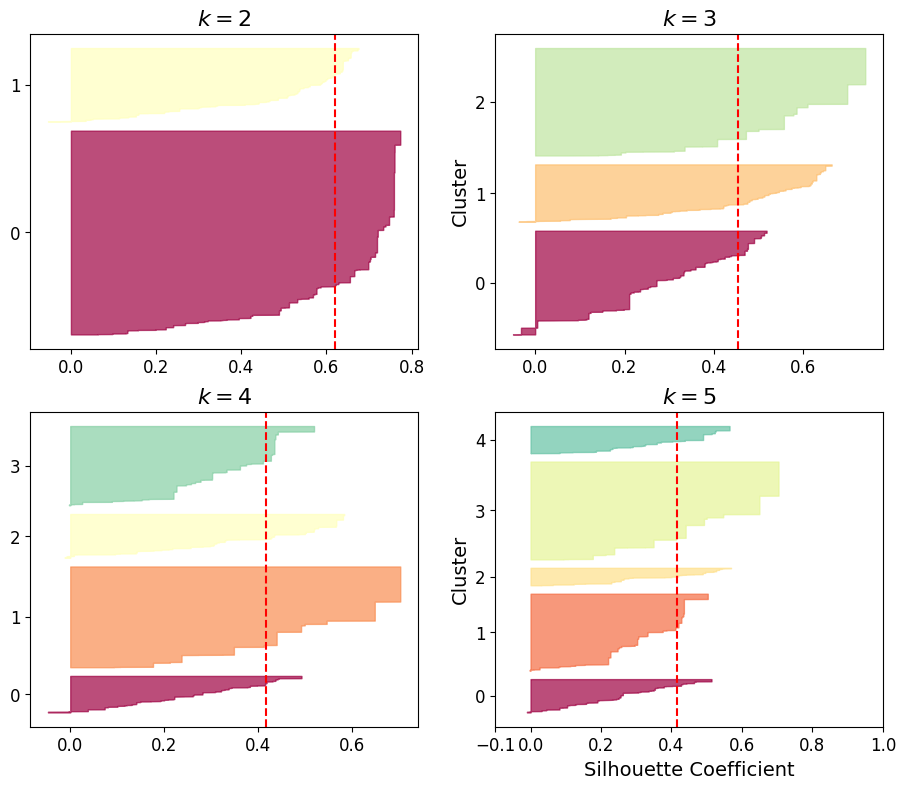

In [85]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k-2+1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()


### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

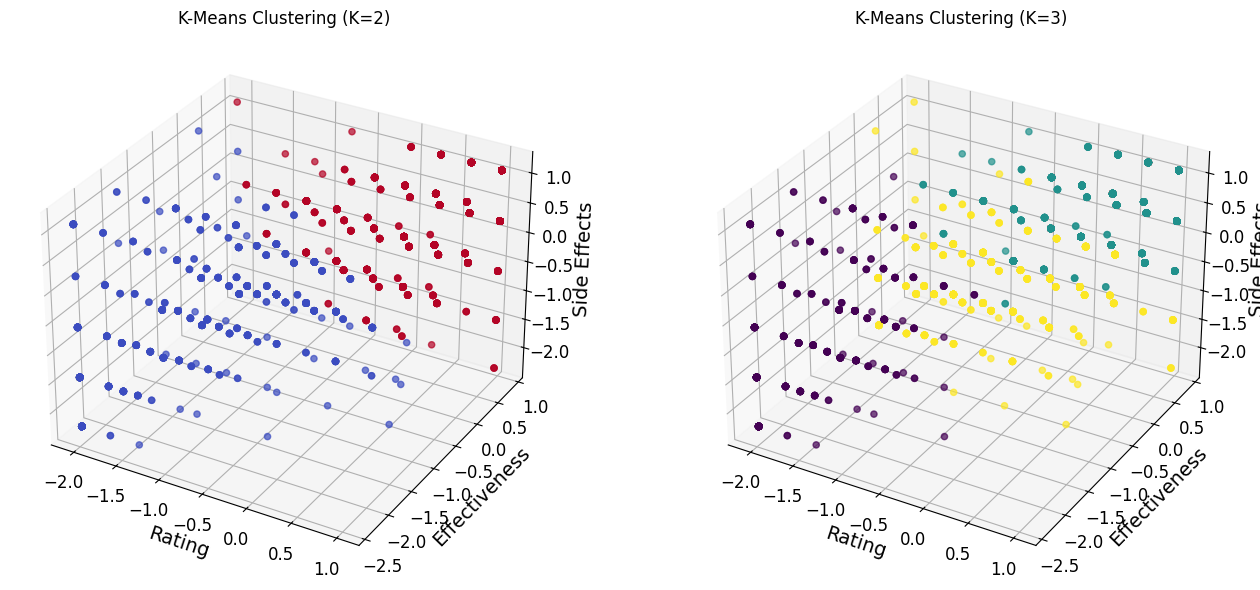

In [86]:
# Aplicar K-Means para K=2 y K=3
kmeans_2 = KMeans(n_clusters=2, random_state=25, n_init=10)
kmeans_3 = KMeans(n_clusters=3, random_state=25, n_init=10)

# Ajustar los modelos
clusters_2 = kmeans_2.fit_predict(X_scaled)
clusters_3 = kmeans_3.fit_predict(X_scaled)

# Agregar las etiquetas de cluster al DataFrame
X_kmeans = X_scaled.copy()
X_kmeans["Cluster_K2"] = clusters_2
X_kmeans["Cluster_K3"] = clusters_3

# Crear gráficos 3D
fig = plt.figure(figsize=(14, 6))

# 3D Scatterplot para K=2
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_kmeans["rating"], X_kmeans["effectiveness"], X_kmeans["sideEffects"], 
            c=X_kmeans["Cluster_K2"], cmap="coolwarm", alpha=0.7)
ax1.set_title("K-Means Clustering (K=2)")
ax1.set_xlabel("Rating")
ax1.set_ylabel("Effectiveness")
ax1.set_zlabel("Side Effects")

# 3D Scatterplot para K=3
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_kmeans["rating"], X_kmeans["effectiveness"], X_kmeans["sideEffects"], 
            c=X_kmeans["Cluster_K3"], cmap="viridis", alpha=0.7)
ax2.set_title("K-Means Clustering (K=3)")
ax2.set_xlabel("Rating")
ax2.set_ylabel("Effectiveness")
ax2.set_zlabel("Side Effects")

plt.tight_layout()
plt.show()

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

            rating                                               
             count      mean       std  min  25%  50%   75%   max
Cluster_K2                                                       
0            883.0  3.026048  1.950755  1.0  1.0  3.0   5.0  10.0
1           2224.0  8.586331  1.325453  1.0  8.0  9.0  10.0  10.0


<Figure size 1000x600 with 0 Axes>

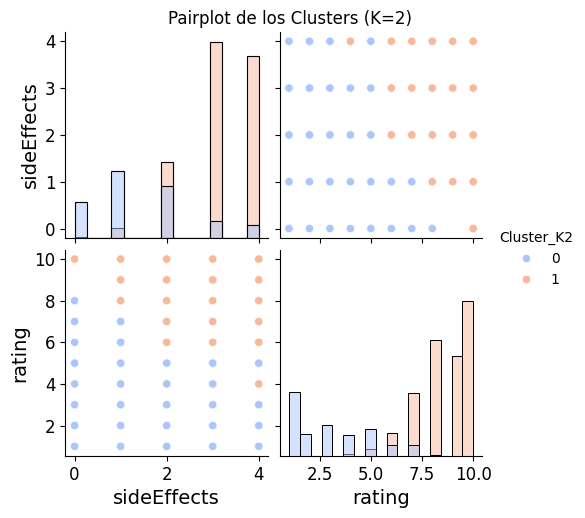

In [87]:
# Aplicar K-Means con K=2
kmeans_2 = KMeans(n_clusters=2, random_state=25, n_init=10)
clusters_2 = kmeans_2.fit_predict(X_scaled)

# Agregar etiquetas de cluster al DataFrame original
X_kmeans = X.copy()
X_kmeans["Cluster_K2"] = clusters_2

# Obtener estadísticas descriptivas por cluster
describe_clusters = X_kmeans.groupby("Cluster_K2").describe()
print(describe_clusters)

# Pairplot para visualizar la distribución de los clusters
plt.figure(figsize=(10, 6))
sns.pairplot(X_kmeans, vars=["sideEffects", "rating"], hue="Cluster_K2", palette="coolwarm", diag_kind="hist")
plt.suptitle("Pairplot de los Clusters (K=2)", y=1.02)

plt.show()

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.